In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from backtesting import Backtest, Strategy
import yfinance as yf
import pandas as pd

TICKERS = [
    'AAPL','MSFT','GOOGL','AMZN','META','NVDA','TSLA','NFLX','CRM','ORCL',
    'BRK-B',
    'JPM','BAC','WFC','MA','V','USB',
    'JNJ','UNH','LLY','PFE','MRK','ABBV','ABT','TMO','GILD',
    'WMT','COST','PG','KO','PEP','HD','MCD','NKE','DIS',
    'XOM','CVX','LIN',
    'HON','DHR','ACN',
    'INTC','AMD','AVGO','TXN','QCOM','CSCO'
]
START, END = "2020-01-01", "2025-06-20"
VOL_WINDOW = 20
MA_WINDOW = 50
MAX_POSITION = 9
SL = -0.05
VIX_THRESHOLD = 35
MAX_HOLD_DAYS = 90



C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\backtesting\_plotting.py:53: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = yf.download(TICKERS, start=START, end=END)["Close"]
vix = yf.download("^VIX", start=START, end=END)["Close"].reindex(data.index).ffill()

C:\Users\admin\AppData\Local\Temp\ipykernel_17920\3736540186.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKERS, start=START, end=END)["Close"]
[*********************100%***********************]  47 of 47 completed
C:\Users\admin\AppData\Local\Temp\ipykernel_17920\3736540186.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=START, end=END)["Close"].reindex(data.index).ffill()
[*********************100%***********************]  1 of 1 completed


In [3]:
daily_returns = data.pct_change()
annual_vol = daily_returns.rolling(VOL_WINDOW).std() * np.sqrt(252)
trend_ma = data.rolling(MA_WINDOW).mean()

def pick_low_volatility(
        vol_row: pd.Series,
        price_row: pd.Series,
        ma_row: pd.Series,
        n: int = MAX_POSITION
) -> pd.Series:
    in_uptrend = price_row  > ma_row
    ranked_vol = vol_row.where(in_uptrend).rank(method="first")
    min_vol = ranked_vol.nsmallest(n).index

    return pd.Series(price_row.index.isin(min_vol), index=price_row.index)


signals = pd.DataFrame(
    [
        pick_low_volatility(
            annual_vol.loc[date],
            data.loc[date],
            trend_ma.loc[date]
        )
        for date in data.index
    ],
    index=data.index,
    columns=data.columns,
).astype(bool)

In [4]:
print(signals)

Ticker       AAPL  ABBV    ABT    ACN    AMD   AMZN   AVGO    BAC  BRK-B  \
Date                                                                       
2020-01-02   True  True   True   True   True   True   True   True   True   
2020-01-03   True  True   True   True   True   True   True   True   True   
2020-01-06   True  True   True   True   True   True   True   True   True   
2020-01-07   True  True   True   True   True   True   True   True   True   
2020-01-08   True  True   True   True   True   True   True   True   True   
...           ...   ...    ...    ...    ...    ...    ...    ...    ...   
2025-06-12  False  True  False   True  False  False  False  False  False   
2025-06-13  False  True   True  False  False  False  False  False  False   
2025-06-16  False  True   True   True  False  False  False  False  False   
2025-06-17  False  True   True   True  False  False  False  False  False   
2025-06-18  False  True   True   True  False  False  False  False  False   

Ticker     

In [5]:
class MultiAssetVolTrading(Strategy):
    n_slots      = MAX_POSITION     
    stop_pct     = SL   
    vix_level    = VIX_THRESHOLD   
    max_holding  = MAX_HOLD_DAYS      

    def init(self):
        self.bar_clock     = 0       
        self.entry_bar_idx = None    

    def next(self):
        self.bar_clock += 1

        if self.stop_pct is not None:
            for tr in self.trades:          
                if tr.pl_pct < self.stop_pct:
                    tr.close()

        if self.position and self.entry_bar_idx is not None:
            if self.bar_clock - self.entry_bar_idx >= self.max_holding:
                self.position.close()
                self.entry_bar_idx = None

        in_sig = bool(self.data.Signal[-1])
        vix_block = (self.vix_level is not None and
                     self.data.VIX[-1] > self.vix_level)

        if in_sig and not self.position and not vix_block:
            alloc_cash = self._broker._cash / self.n_slots   
            price      = self.data.Close[-1]
            shares     = int(alloc_cash / price)
            if shares < 1:
                return
            self.buy(size=shares)
            self.entry_bar_idx = self.bar_clock

        elif (not in_sig) and self.position:
            self.position.close()
            self.entry_bar_idx = None

    def stop(self):
        if self.position:
            self.position.close()


In [6]:
stats, curves = {}, []

for ticker in TICKERS:
    sig = signals[ticker].reindex(data.index).ffill()
    df = pd.DataFrame({
        "Close": data[ticker].squeeze(),
        "Signal": signals[ticker].squeeze(),
        "VIX": vix.squeeze()
    })

    df = (df.assign(Open=df["Close"], High=df["Close"], Low=df["Close"])
          [["Open", "High", "Low", "Close", "Signal", "VIX"]].dropna())
    
    bt = Backtest(df, MultiAssetVolTrading, cash=10000, commission=0.001)
    s = bt.run()
    stats[ticker] = s
    curves.append(s["_equity_curve"]["Equity"].rename(ticker))

In [7]:
INIT_CAP  = 100_000          

equity_df = pd.concat(curves, axis=1)          
pl_df     = equity_df.sub(INIT_CAP)            
total_pl  = pl_df.sum(axis=1)                  
PORT_EQ   = INIT_CAP + total_pl               
port_ret  = PORT_EQ.pct_change().fillna(0) 

In [8]:
def sharpe(r):
    return r.mean() / r.std() * np.sqrt(252)

summary = pd.DataFrame({
    "Return [%]":  (PORT_EQ.iloc[-1] / PORT_EQ.iloc[0] - 1) * 100,
    "Sharpe Ratio": sharpe(port_ret),
    "Max DD [%]": 100 * (PORT_EQ.cummax() - PORT_EQ).max()
                       / PORT_EQ.cummax().max(),
    "# Trades":   signals.diff().abs().sum().sum()
}, index=["Portfolio"])

print("=== Portfolio summary ===")
print(summary.round(2))

=== Portfolio summary ===
           Return [%]  Sharpe Ratio  Max DD [%]  # Trades
Portfolio       -0.01         -0.06       -0.07      3628


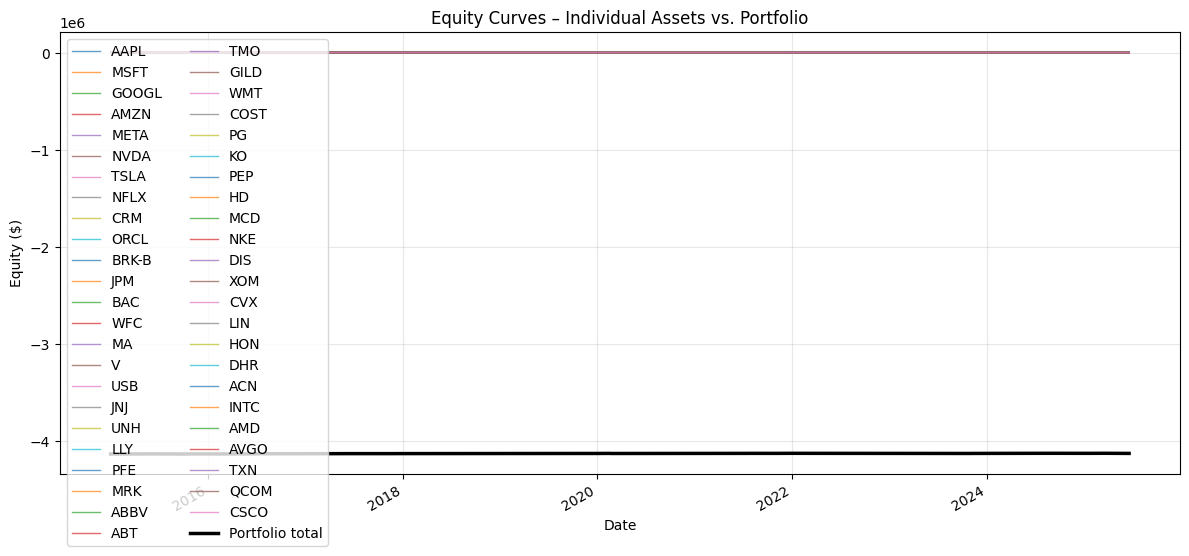

In [37]:

import plotly.graph_objects as go
import matplotlib.pyplot as plt

equity_curves = pd.concat(curves, axis=1)      
equity_curves.columns.name = "Symbol"

fig, ax = plt.subplots(figsize=(12, 6))

equity_curves.plot(ax=ax, lw=1.0, alpha=0.7)

PORT_EQ.plot(ax=ax, color="black", lw=2.5, label="Portfolio total")

ax.set_title("Equity Curves – Individual Assets vs. Portfolio")
ax.set_ylabel("Equity ($)")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left", ncol=2)

plt.tight_layout()
plt.show()

In [38]:

import plotly.graph_objects as go

fig = go.Figure()

for col in equity_curves.columns:
    fig.add_trace(go.Scatter(
        x=equity_curves.index, y=equity_curves[col],
        mode="lines", name=col, line=dict(width=3)))

fig.add_trace(go.Scatter(
    x=PORT_EQ.index, y=PORT_EQ,
    mode="lines", name="Portfolio total", line=dict(width=6, color="white")))

fig.update_layout(
    title="Equity Curves – Individual Assets vs. Portfolio",
    xaxis_title="Date", yaxis_title="Equity ($)",
    plot_bgcolor='black',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    legend=dict(orientation="h", yanchor="bottom", y=1.02),
    width=1200, height=800) 

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [39]:
wanted = ["Return [%]", "Sharpe Ratio", "Max. Drawdown [%]", "# Trades"]

per_ticker = (
    pd.DataFrame({t: {m: s[m] for m in wanted}
                  for t, s in stats.items()})
      .T
)

per_ticker["Days in basket"] = signals.sum()

vix_ok   = (vix <= VIX_THRESHOLD).to_numpy().reshape(-1, 1)   # (n_days, 1)
eligible = signals & vix_ok                               # DataFrame[bool]
per_ticker["Days VIX≤limit"] = eligible.sum()

entry_setups = (eligible & ~eligible.shift(fill_value=False)).sum()
per_ticker["Entry setups"] = entry_setups

held = {}
for t in TICKERS:
    trades = stats[t]["_trades"]
    held[t] = 0 if trades.empty else (trades["ExitBar"] - trades["EntryBar"] + 1).sum()
per_ticker["Days held"] = pd.Series(held)

cols = wanted + ["Entry setups", "Days held", "Days VIX≤limit", "Days in basket"]
per_ticker = per_ticker[cols].sort_values("Return [%]", ascending=False)

print("\n=== Single-ticker stats (with diagnostics) ===")
per_ticker.round(2)


=== Single-ticker stats (with diagnostics) ===


,Return [%],Sharpe Ratio,Max. Drawdown [%],# Trades,Entry setups,Days held,Days VIX≤limit,Days in basket
BRK-B,16.43,0.76,-3.26,64.0,69,1071,972,1063
DHR,14.70,0.32,-1.58,24.0,26,207,178,238
PG,7.58,0.36,-4.50,68.0,83,1161,1009,1118
COST,7.38,0.42,-3.54,39.0,44,547,460,588
HON,6.09,0.50,-4.20,38.0,38,397,354,366
WMT,5.25,0.30,-5.14,38.0,40,621,571,677
ABT,4.44,0.37,-1.76,12.0,14,248,250,270
KO,3.98,0.17,-4.72,56.0,66,1342,1241,1376
MCD,3.94,0.19,-4.64,55.0,71,1160,1017,1184
ACN,3.34,0.24,-2.28,23.0,24,289,260,274


In [40]:

import plotly.graph_objects as go

fig = go.Figure()

for col in equity_curves.columns:
    fig.add_trace(go.Scatter(
        x=equity_curves.index, y=equity_curves[col],
        mode="lines", name=col, line=dict(width=3)))

fig.update_layout(
    title="Equity Curves – Individual Assets vs. Portfolio",
    xaxis_title="Date", yaxis_title="Equity ($)",
    plot_bgcolor='black',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    legend=dict(orientation="h", yanchor="bottom", y=1.02),
    width=1200, height=800)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [41]:
vix.describe()

Ticker,^VIX
count,2631.000000
mean,18.404629
std,7.284520
min,9.140000
25%,13.435000
50%,16.540001
75%,21.450000
max,82.690002
